# Example iPython Code for the CosmicWatch Muon Detector

This script can be used to make some simple plots using iPython.
You'll require some imports, all of which are in the next cell.

The CWClass class alows you to give it a file name and locations and it will parse the data
to make it more user friendly. For example:

myCWData = CWClass('file_location/M0001.txt',bin_size = 120)

ADC_values = myCWData.adc

ADC_values will be an array of the ADC measurements, event by event.

The bin_size argument is for binning the data into time intervals in seconds. For example, if you
want to look at the count rate in ten minute intervals, set it to 600.

The way that I like to plot data is to define a class that takes lists of different measurements.
For example, you'll see that when I plot two files a few cells down, the data is set like this:

data = [f1.sipm,f2.sipm]

The code will loop through the number of entries in the list, and plot them independently on the 
same fig. So this plot will include both the SiPM voltage values from file 1 (f1) and file 2 (f2).


In [1]:
#***********************************************************************************
# Master import
#***********************************************************************************

# Plot data in the window
%matplotlib inline
# Make the cell width the size of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports
import glob
import sys
import pylab
from pylab import *
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import time
import numpy as np
import os

# Fontsize
font = { 'size':   24}
matplotlib.rc('font', **font)

'''
# Allow it to use Latex notation
plt.rc('text', usetex=True)
'''
# Define your own colors for the plots
mycolors = ['#c70039','#ff5733','#ff8d1a','#ffc300','#eddd53','#add45c','#57c785',
               '#00baad','#2a7b9b','#3d3d6b','#511849','#900c3f','#900c3f'] 

#***********************************************************************************
# Master import
#***********************************************************************************
print('Imports complete ...')

Imports complete ...


In [2]:
# ***********************************************************************************
# CWClass
# This class is used to import CW data and use it easily. It will use either the 
# data recorded by the computer or from the microSD Card.
#
# Arguments:
#    1. fname: 
#       location and name of the file that you want to plot
#    2. bin_size:
#       When plotting rate as a function of time, you need to specify the rate over
#       a given interval. "bin_size" is the interval in seconds. Default is 60s.
#***********************************************************************************

class CWClass():
    def __init__(self,fname,bin_size = 60):
        self.name = fname.split('/')[-1]
        self.bin_size = bin_size
        
        fileHandle = open(fname,"r" )
        lineList = fileHandle.readlines()
        fileHandle.close()
        header_lines = 0
        
        # Look through the first 1000 lines for the word "Device". Everything prior is considered part of the header.
        for i in range(min(len(lineList),1000)):
            header_in_file = lineList[i]
            if 'Device' in header_in_file:
                header_lines = i+1
  
        #Determine number of columns by looking at the second last line in the file.
        number_of_columns = len(lineList[len(lineList)-2].split(" "))
        column_array = range(0,number_of_columns)

        
        file_from_computer = False
        file_from_sdcard   = False
        
        if number_of_columns == 9:
            file_from_computer = True  # If you have 9 columns, you probably took the data on the computer 
            data = np.genfromtxt(fname, dtype = str, delimiter=' ', usecols=column_array, invalid_raise=False, skip_header=header_lines)
            comp_date = data[:,0] #first column of data
            comp_time = data[:,1]
            event_number = data[:,2].astype(np.float)
            Ardn_time_ms = data[:,3].astype(np.float)
            adc = data[:,4].astype(np.float)
            sipm = data[:,5].astype(np.float)
            deadtime = data[:,6].astype(np.float)
            temperature = data[:,7].astype(np.float)
            detName = data[:,8]
            
        elif number_of_columns == 6:
            file_from_sdcard = True # If you have 6 columns, you took the data from the sdCard
            data = np.genfromtxt(fname, dtype = str, delimiter=' ', usecols=column_array, invalid_raise=False, skip_header=header_lines)
            event_number = data[:,0].astype(np.float)
            Ardn_time_ms = data[:,1].astype(np.float)
            adc = data[:,2].astype(np.float)
            sipm = data[:,3].astype(np.float)
            deadtime = data[:,4].astype(np.float)
            temperature = data[:,5].astype(np.float)
            
        else: 
            print('The file format is unknown, or older. If it is an older file format, you will have to change the number of columns in the CW class.')
            
            
        # Simple check to see if the events are sequential
        def sequential(l):
            l = np.asarray(l).astype(np.int)
            check = range(min(l),max(l)+1)

            if len(l)!=len(check):
                print('There is an event missing in the data.')
                return False

            counter = 0
            for i in range(len(l)):
                counter+=1
                if l[i]!=check[i]:
                    print('Check event number: '+str(counter))
            return sum(check == l)==len(l)

        if not sequential(event_number):
            print('Events in file are not sequential.')

        # Convert the computer time to an absolute time (MJD).
        if file_from_computer:
            time_stamp = []
            for i in range(len(comp_date)):
                year  = int(comp_date[i].split('-')[0])
                month = int(comp_date[i].split('-')[1])
                day   = int(comp_date[i].split('-')[2])
                hour  = int(comp_time[i].split(':')[0])
                mins  = int(comp_time[i].split(':')[1])
                sec   = int(np.floor(float(comp_time[i].split(':')[2])))
                try:  
                    decimal = float('0.'+str(comp_time[i].split('.')[-1]))
                except:
                    decimal = 0.0
                time_stamp.append(float(time.mktime((year, month, day, hour, mins, sec, 0, 0, 0)))+ decimal) 


            self.time_stamp_s     = np.asarray(time_stamp) -  min(np.asarray(time_stamp))       # The absolute time of an event in seconds
            self.time_stamp_ms    = np.asarray(time_stamp -  min(np.asarray(time_stamp)))*1000  # The absolute time of an event in miliseconds   
            self.total_time_s     = max(time_stamp) -  min(time_stamp)     # The absolute time of an event in seconds
            self.detector_name    = detName                                
            self.n_detector       = len(set(detName))

        # Convert the cumulative deadtime to the deadtime between events
        # The detector starts at time 0, so append a zero.
        event_deadtime_ms = diff(np.append([0],deadtime))

        # The Arduino absolute time isn't great. Over the course of a few hours, it will be off by several seconds. 
        # The computer will give you accurate time down to about 1ms. Reading from the serial port has ~ms scale uncertainty.
        # The Arduino can give you a precise measurement (down to 1us), but the absolute time will drift. Expect it to be off by roughly 1min per day.
        self.Ardn_time_ms      = Ardn_time_ms
        self.Ardn_time_s       = Ardn_time_ms/1000.
        
        self.Ardn_total_time_s = max(self.Ardn_time_s)
        self.Ardn_total_time_ms= max(self.Ardn_time_s)*1000.

        self.event_number     = np.asarray(event_number)  # an arrray of the event numbers
        self.total_counts     = max(event_number.astype(int)) - min(event_number.astype(int))
        self.adc              = adc         # an arrray of the measured event ADC value
        self.sipm             = sipm        # an arrray of the measured event SiPM value
        
        self.event_deadtime_s   = event_deadtime_ms/1000.      # an array of the measured event deadtime in seconds
        self.event_deadtime_ms  = event_deadtime_ms            # an array of the measured event deadtime in miliseconds
        self.total_deadtime_ms  = max(event_deadtime_ms)       # an array of the measured event deadtime in miliseconds
        self.total_deadtime_s   = max(event_deadtime_ms)/1000. # The total deadtime in seconds
                
        # The time between events is well described by the Arduino timestamp. 
        # The 'diff' command takes the difference between each element in the array.
        self.Ardn_event_livetime_s = diff(np.append([0],self.Ardn_time_s)) - self.event_deadtime_s
        

        if file_from_computer:
            self.live_time        = (self.total_time_s - self.total_deadtime_s)
            self.weights          = np.ones(len(event_number)) / self.live_time
            self.count_rate       = self.total_counts/self.live_time 
            self.count_rate_err   = np.sqrt(self.total_counts)/self.live_time 

            bins = range(0,int(max(self.time_stamp_s)), self.bin_size)
            counts, binEdges       = np.histogram(self.time_stamp_s, bins = bins)
            bin_livetime, binEdges = np.histogram(self.time_stamp_s, bins = bins, weights = self.Ardn_event_livetime_s)
        
        elif file_from_sdcard:
            self.live_time        = (self.Ardn_total_time_ms - self.total_deadtime_ms)/1000.
            self.weights          = np.ones(len(event_number)) / self.live_time
            self.count_rate       = self.total_counts/self.live_time 
            self.count_rate_err   = np.sqrt(self.total_counts)/self.live_time 

            bins = range(int(min(self.Ardn_time_s)),int(max(self.Ardn_time_s)),self.bin_size)
            counts, binEdges = np.histogram(self.Ardn_time_s, bins = bins)
            bin_livetime, binEdges = np.histogram(self.Ardn_time_s, bins = bins, weights = self.Ardn_event_livetime_s)
            
        else:
            print('Error')
        
        print('Count rate: '+str(np.round(self.count_rate,4)) +' +/- '+ str(np.round(self.count_rate_err,4)))
        
        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        
        self.bin_size          = bin_size
        self.binned_counts     = counts
        self.binned_counts_err = np.sqrt(counts)
        self.binned_count_rate = counts/bin_livetime
        self.binned_count_rate_err = np.sqrt(counts)/bin_livetime
        self.binned_time_s     = bincenters
        self.binned_time_m     = bincenters/60.

    
        
def plusSTD(n,array):
    xh = np.add(n,np.sqrt(np.abs(array)))
    return xh

def subSTD(n,array):
    xl = np.subtract(n,np.sqrt(np.abs(array)))
    return xl

def fill_between_steps(x, y1, y2=0, h_align='mid', ax=None,lw=2, **kwargs):
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:]
    # Now: the average x binwidth
    xstep = sp.repeat((x[1:] - x[:-1]), 2)
    xstep = sp.concatenate(([xstep[0]], xstep, [xstep[-1]]))
    # Now: add one step at end of row.
    xx = sp.append(xx, xx.max() + xstep[-1])

    # Make it possible to chenge step alignment.
    if h_align == 'mid':
        xx -= xstep / 2.
    elif h_align == 'right':
        xx -= xstep

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == sp.ndarray:
        y2 = y2.repeat(2)#[:-1]

    # now to the plotting part:
    ax.fill_between(xx, y1, y2=y2,lw=lw, **kwargs)
    return ax

print('Definitions complete ...')

Definitions complete ...


# Example Multiple histogram 

In [3]:
class NPlot():
    def __init__(self, 
                 data,
                 weights,
                 colors,
                 labels,
                 xmin,xmax,ymin,ymax,
                 figsize = [10,10],fontsize = 18,nbins = 101, alpha = 0.9,
                 xscale = 'log',yscale = 'log',xlabel = '',loc = 1,pdf_name='',lw=2, title=''):
        
        fig = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = fig.add_subplot(111)

        if xscale == 'log':
            bins = np.logspace(np.log10(xmin),np.log10(xmax),nbins)
        if xscale == 'linear':
            bins = np.linspace(xmin,xmax,nbins)
    
        for i in range(len(data)):
            counts,binEdges = np.histogram(data[i][~np.isnan(data[i])],bins = bins,weights = weights[i][~np.isnan(weights[i])],range= (200,1024))
            bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
            sumWeightsSqrd, binEdges = np.histogram(data[i][~np.isnan(data[i])], bins = bins, weights = np.power(weights[i][~np.isnan(weights[i])],2),range= (200,1024))
            fill_between_steps(bincenters, plusSTD(counts,sumWeightsSqrd),subSTD(counts,sumWeightsSqrd),  color = colors[i],alpha = alpha,lw=lw)
            pylab.plot([1e14,1e14], label = labels[i],color = colors[i],alpha = alpha,linewidth = 2)
        
        pylab.yscale(yscale, nonposy='clip')
        pylab.xscale(xscale, nonposx='clip')
        pylab.grid(b=True, which='major', color='k', alpha = 0.1,linestyle='-')
        pylab.grid(b=True, which='minor', color='k',alpha = .05,  linestyle='-')
        pylab.legend(fontsize=fontsize-2,loc = loc,  fancybox = True,frameon=True)
        pylab.ylabel(r'Rate/bin [s$^{-1}$]',size=fontsize)
        pylab.xlabel(xlabel, labelpad=20,size=fontsize)
        pylab.axis([xmin, xmax, ymin,ymax])
        plt.title(title,fontsize=fontsize)
        pylab.tight_layout()
        if pdf_name != '':
            plt.savefig(pdf_name, format='pdf',transparent =True)
        pylab.show()


In [4]:
# Load data that was taken from a computer
#    1. Give the name of the file
#    2. Give the size of binning in time you would like
cwd = os.getcwd()
f1 = CWClass(cwd + "/Sheilding/bkg_nobox_long.txt", bin_size = 60)
f2 = CWClass(cwd + "/Sheilding/bkg_nobox_sheild_long.txt", bin_size = 60)

Count rate: 0.9032 +/- 0.011
Count rate: 0.4719 +/- 0.0062


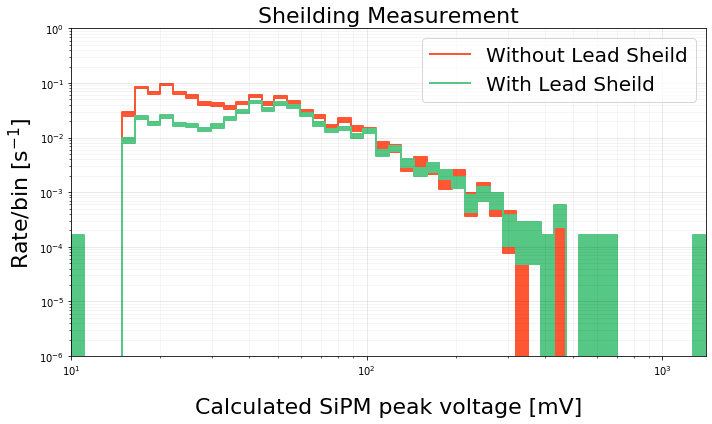

In [5]:
# Plot data
c = NPlot(data = [f1.sipm,f2.sipm], 
    weights = [f1.weights, f2.weights],
    colors = [mycolors[1],mycolors[6]],
    labels = [r'Without Lead Sheild',r'With Lead Sheild'],
    figsize = [10,6],
    fontsize = 22,
    xmin = 10, xmax = 1400,ymin = 0.1e-5,ymax = 1,
    nbins =  51, alpha = 1, lw=2,
    xscale = 'log',yscale = 'log',
    xlabel = 'Calculated SiPM peak voltage [mV]',
    title = 'Sheilding Measurement',
    loc = 1, pdf_name='')

# Example Rate plot

In [6]:
class ratePlot():
    def __init__(self,
                 time,
                 count_rates,
                 count_rates_err,
                 colors,
                 labels,
                 xmin,xmax,ymin,ymax,
                 figsize = [10,10],fontsize = 18, alpha = 0.9,
                 xscale = 'linear',yscale = 'linear',
                 xlabel = '',ylabel = '',
                 loc = 1,pdf_name='',title = ''):
        
        f = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = f.add_subplot(111)

        for i in range(len(count_rates)):
            pylab.errorbar(time[i], 
                           count_rates[i],
                           xerr=0, yerr=count_rates_err[i],
                           fmt= 'ko',label = labels[i], linewidth = 2, ecolor = colors[i], markersize = 2)

        pylab.yscale(yscale, nonposy='clip')
        pylab.xscale(xscale, nonposx='clip')
        pylab.ylabel(ylabel)
        pylab.xlabel(xlabel)
        pylab.axis([xmin, xmax, ymin,ymax])
        #ax1.xaxis.set_label_coords(0.5, 0.3)
        ax1.xaxis.labelpad = 0 
        pylab.legend(loc=loc, shadow=True,fontsize = 24,frameon = 0,fancybox = True)
        pylab.tight_layout()
        plt.title(title)
        if pdf_name != '':
            plt.savefig(pdf_name, format='pdf',transparent =True)
        pylab.show()
        

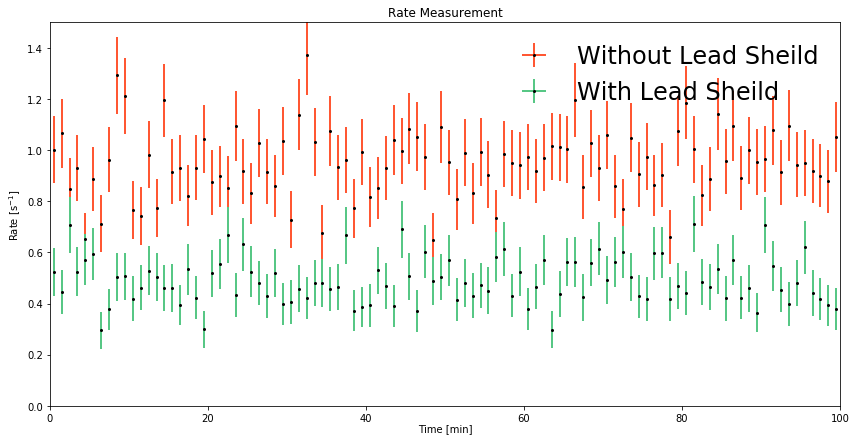

In [7]:
c = ratePlot(time = [f1.binned_time_m,f2.binned_time_m],
             count_rates = [f1.binned_count_rate,f2.binned_count_rate],
             count_rates_err = [f1.binned_count_rate_err,f2.binned_count_rate_err],
             colors =[mycolors[1],mycolors[6]],
             labels = [r'Without Lead Sheild',r'With Lead Sheild'],
             xmin = 0,xmax = 100,ymin = 0,ymax = 1.5,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement')


# Example Angle Plot

In [8]:
class anglePlot():
    def __init__(self,
                 angles,            # a list, file angles
                 count_rates,       # a list, file count rates
                 count_rates_err,   # a list, file count rates
                 figsize = [8,6],fontsize = 18, alpha = 0.9,
                 loc = 1,pdf_name=''):
        
        fig = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = fig.add_subplot(111)
        
        x = np.linspace(-0.020, np.pi, 100)
        y = np.cos(x)**2
        
        # Convert angles into radians
        angles = np.asarray(angles)* np.pi /180.
        
        # The error in the angle is the approximate solid angle that is able to count a muon.
        angles_err = []
        
        rate = []
        
        # If the angle 
        for i in range(len(count_rates)):
            if angles[i] > 0.95*np.pi/2 and angles[i] < 1.05*np.pi/2.:
                min_rate = count_rates[i]#/2.
                
        for i in range(len(count_rates)): 
            #if angles[i] > 0.95*np.pi/2 and angles[i] < 1.05*np.pi/2.:
            #    angles_err.append(6.*np.pi / 180./2.)
            #    rate.append(count_rates[i]/2.)# - min_rate)
            #else:
            rate.append(count_rates[i])# - min_rate*(1-np.cos(angles[i])**2))
            angles_err.append(12*np.pi / 180./2)
        
        # We scale everything such that the max count rate is a 1.0
        count_rates_err = np.asarray(count_rates_err)/max(count_rates)
        
        rate = np.divide(rate,max(rate))

        pylab.axis([-0.020,1.6, 0.,1.1])
        pylab.ylabel(r'Normalized Rate [s$^{-1}$]')
        pylab.xlabel(r'$\theta$ [rad]')
        pylab.yscale('linear', nonposy='clip')
        pylab.xscale('linear', nonposx='clip')

        pylab.plot(x, y, 'b', label=r"I $\propto$ cos$^2\theta$")
        pylab.errorbar(angles, rate, xerr=angles_err, yerr=count_rates_err, fmt='ok',label = 'Data')
        pylab.legend(fontsize=fontsize,loc = 1,  fancybox = True,frameon=True)
        pylab.tight_layout()
        if pdf_name != '':
            pylab.savefig(pdf_name, format='pdf',transparent =True)
        pylab.show()

In [10]:
# Load microSD card file 
cwd = os.getcwd()

a1 = CWClass(cwd+"/Angular_Measurement/Slave_0deg.txt", bin_size = 120)
a2 = CWClass(cwd+"/Angular_Measurement/Slave_45deg.txt", bin_size = 120)
a3 = CWClass(cwd+"/Angular_Measurement/Slave_90deg.txt", bin_size = 120)

Count rate: 0.0073 +/- 0.0003
Count rate: 0.0048 +/- 0.0003
Count rate: 0.0013 +/- 0.0001


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in true_divide


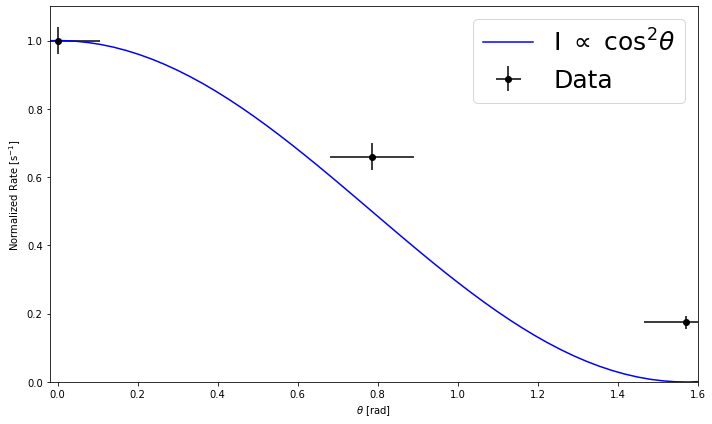

In [11]:
c = anglePlot(angles = [0,45,90],
    count_rates = [a1.count_rate,a2.count_rate,a3.count_rate],
    count_rates_err = [a1.count_rate_err,a2.count_rate_err,a3.count_rate_err],
    figsize = [10,6],fontsize = 25, alpha = 0.9,
    pdf_name='')